# setup

In [1]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
import torch
import torch.nn as nn

from tqdm import tqdm
from scipy.signal import butter, lfilter

from models.baseline import ResnetBaseline
from runners.train import Runner

In [3]:
from dataloaders.code import CODE as DS
from dataloaders.code import CODEsplit as DSsplit

# init

In [4]:
database = DS()
model = ResnetBaseline(n_classes = 6)
model = torch.load('output/code/code.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

801it [00:00, 8009.51it/s]

checking exam_id consistency in idx dict


284928it [00:34, 8224.16it/s]
1614it [00:00, 8064.91it/s]

checking exam_id consistency in idx dict


11528it [00:01, 8135.91it/s]
814it [00:00, 8139.60it/s]

checking exam_id consistency in idx dict


284928it [00:34, 8197.61it/s]


In [5]:
runner = Runner(device = device, model = model, database = database, split = DSsplit, model_label = 'code')

using test ds, H is treated as X


# utils

In [6]:
SIGNAL_CROP_LEN = 2560
SIGNAL_NON_ZERO_START = 571

# def get_inputs(batch, apply = "non_zero", device = "cuda"):
def get_inputs(batch, apply = "nothing", device = "cuda"):
    # (B, C, L)
    if batch.shape[1] > batch.shape[2]:
        batch = batch.permute(0, 2, 1)

    B, n_leads, signal_len = batch.shape

    if apply == "non_zero":
        transformed_data = torch.zeros(B, n_leads, SIGNAL_CROP_LEN)
        for b in range(B):
            start = SIGNAL_NON_ZERO_START
            diff = signal_len - start
            if start > diff:
                correction = start - diff
                start -= correction
            end = start + SIGNAL_CROP_LEN
            for l in range(n_leads):
                transformed_data[b, l, :] = batch[b, l, start:end]

    else:
        transformed_data = batch.float()

    return transformed_data.to(device)

In [7]:
from sklearn.metrics import f1_score

def find_best_thresholds(predictions, true_labels_dict, thresholds):
    num_classes = len(predictions[0])
    best_thresholds = [0.5] * num_classes
    best_f1s = [0.0] * num_classes

    for class_idx in (range(num_classes)):
        for thresh in thresholds:
            f1 = f1_score(
                true_labels_dict[class_idx],
                predictions[thresh][class_idx],
                zero_division=0,
            )

            if f1 > best_f1s[class_idx]:
                best_f1s[class_idx] = f1
                best_thresholds[class_idx] = thresh
    
    return best_f1s, best_thresholds

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def metrics_table(all_binary_results, all_true_labels):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []

    num_classes = all_binary_results.shape[-1]
    for class_idx in range(num_classes):
        class_binary_results = all_binary_results[:, class_idx].cpu().numpy()
        class_true_labels = all_true_labels[:, class_idx].cpu().numpy()

        accuracy = accuracy_score(class_true_labels, class_binary_results)
        precision = precision_score(class_true_labels, class_binary_results, zero_division=0)
        recall = recall_score(class_true_labels, class_binary_results, zero_division=0)
        f1 = f1_score(class_true_labels, class_binary_results, zero_division=0)
        auc = roc_auc_score(class_true_labels, class_binary_results)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc)
    
    # normal
    # normal_idx = torch.sum(all_true_labels, dim = 1) == 0
    
    # class_binary_results = torch.sum(all_binary_results, axis = 1).bool()[normal_idx].cpu().numpy()
    # class_true_labels = torch.sum(all_true_labels, axis = 1).bool()[normal_idx].cpu().numpy()
    class_binary_results = (~torch.sum(all_binary_results, axis = 1).bool()).int().cpu().numpy()
    class_true_labels = (~torch.sum(all_true_labels, axis = 1).bool()).int().cpu().numpy()

    accuracy = accuracy_score(class_true_labels, class_binary_results)
    precision = precision_score(class_true_labels, class_binary_results, zero_division=0)
    recall = recall_score(class_true_labels, class_binary_results, zero_division=0)
    f1 = f1_score(class_true_labels, class_binary_results, zero_division=0)
    auc = roc_auc_score(class_true_labels, class_binary_results)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_scores.append(auc)

    metrics_dict = {
        "Accuracy": accuracy_scores,
        # "Precision": precision_scores,
        # "Recall": recall_scores,
        "F1 Score": f1_scores,
        "AUC ROC": auc_scores,
    }

    return metrics_dict

# eval

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from hparams import BATCH_SIZE, NUM_WORKERS

In [10]:
model = model.to(device)
val_dl = torch.utils.data.DataLoader(runner.val_ds, batch_size = BATCH_SIZE, 
                                        shuffle = False, num_workers = NUM_WORKERS)
tst_dl = torch.utils.data.DataLoader(runner.tst_ds, batch_size = BATCH_SIZE, 
                                        shuffle = False, num_workers = NUM_WORKERS)
best_f1s, best_thresholds = runner._synthesis(val_dl, best_thresholds = None)
all_binary_results, all_true_labels, metrics_dict = runner._synthesis(tst_dl, best_thresholds)

100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


In [11]:
metrics_dict

{'Accuracy': [0.9903264812575574,
  0.9939540507859734,
  0.9987908101571947,
  0.9915356711003628,
  0.9963724304715841,
  0.9939540507859734,
  0.9746070133010882],
 'F1 Score': [0.8518518518518519,
  0.9275362318840579,
  0.983050847457627,
  0.8108108108108109,
  0.8695652173913044,
  0.9315068493150684,
  0.9845928099779897],
 'AUC ROC': [0.9088369390309315,
  0.9686966842222386,
  0.9833333333333334,
  0.9650508631319359,
  0.8846153846153846,
  0.9581936366746493,
  0.9549866232172671]}

In [12]:
best_f1s, best_thresholds

([0.591304347826087,
  0.8384754990925591,
  0.8539944903581266,
  0.7071129707112972,
  0.8554913294797687,
  0.7954911433172301],
 [0.16, 0.48, 0.6, 0.37, 0.5700000000000001, 0.42])

In [63]:
tst_dl = torch.utils.data.DataLoader(runner.tst_ds, batch_size = 827, 
                                        shuffle = False, num_workers = NUM_WORKERS)
for batch in (tst_dl):
    raw = batch['X']
    label = batch['y']
    ecg = get_inputs(raw, device = 'cpu')
    label = label.float()

In [13]:
error_idx = torch.sum((all_binary_results != all_true_labels).cpu(), axis = 1).bool()

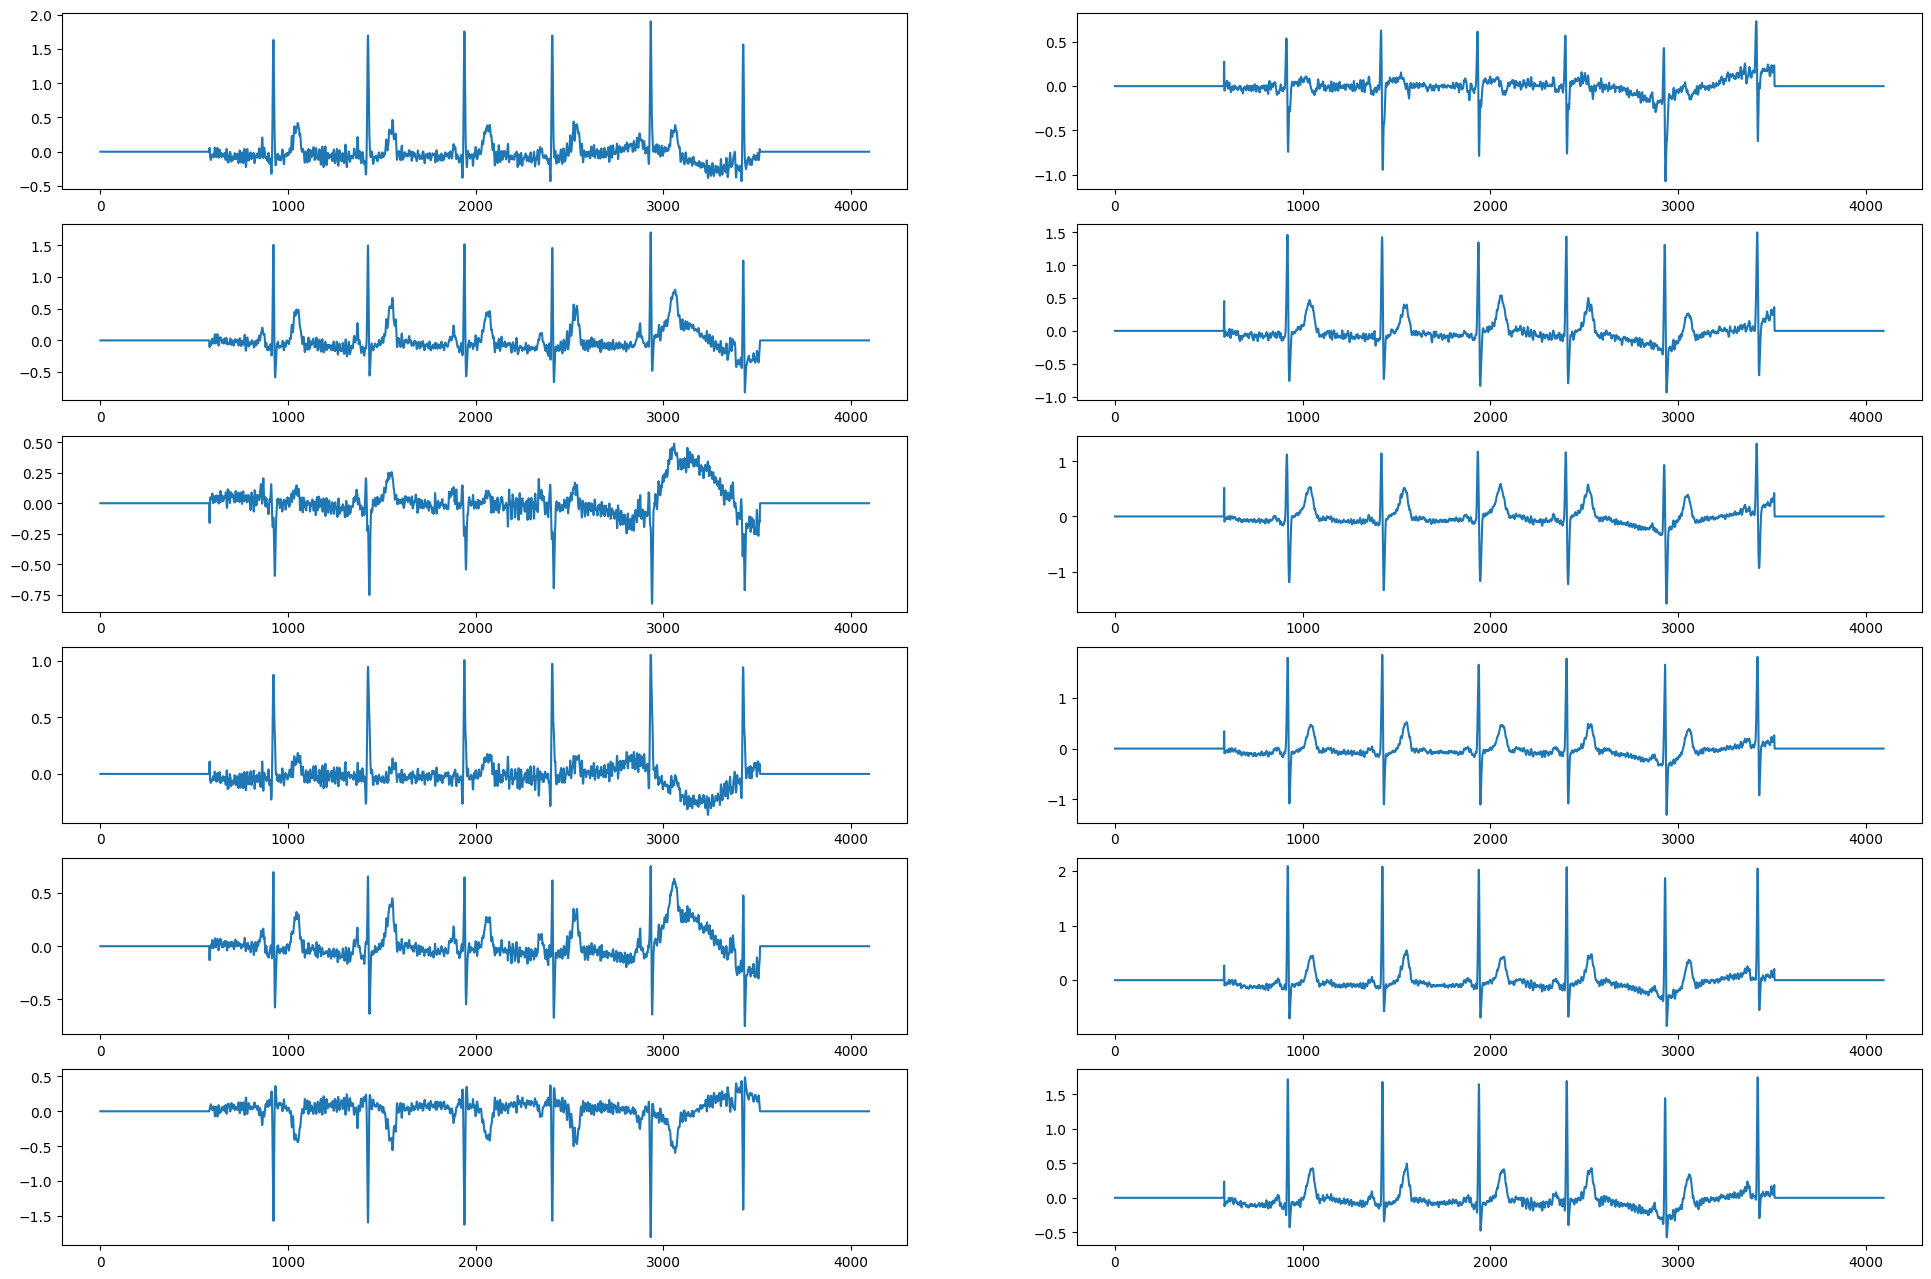

In [14]:
erros = ecg[error_idx]

s = 0
erro = erros[s, :, :]
fig, axs = plt.subplots(6, 2, figsize = (24, 16))
for ii in range(12):
    i = ii % 6
    j = ii // 6
    axs[i, j].plot(erro[ii, :]);

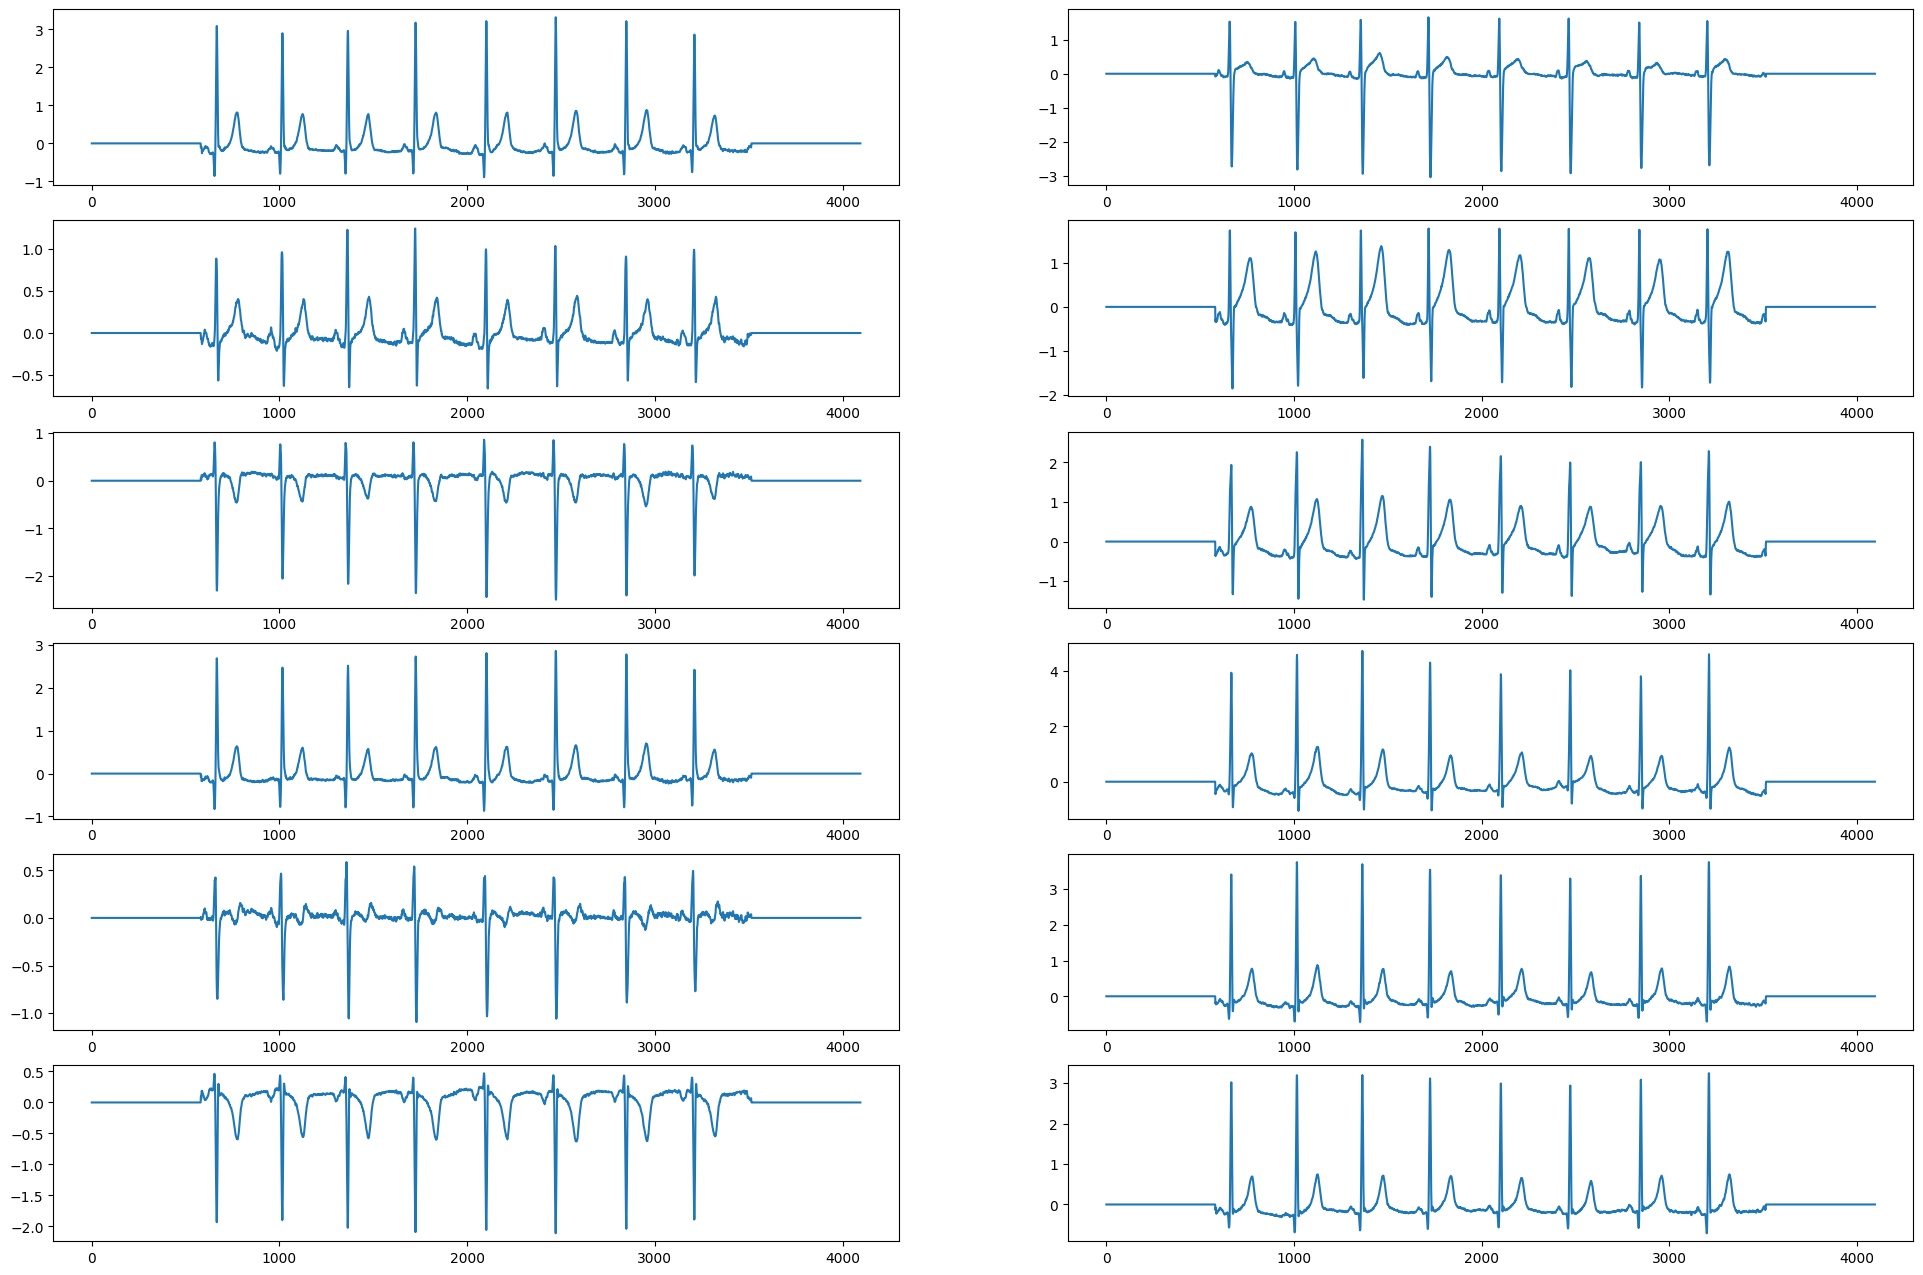

In [15]:
acertos = ecg[~error_idx]

s = 0
acerto = acertos[s, :, :]
fig, axs = plt.subplots(6, 2, figsize = (24, 16))
for ii in range(12):
    i = ii % 6
    j = ii // 6
    axs[i, j].plot(acerto[ii, :]);

In [27]:
raw.shape

torch.Size([827, 4096, 12])

# filtro

In [23]:
fs = 400
cutoff = 4

b, a = butter(N = 2, Wn = cutoff, fs = fs)

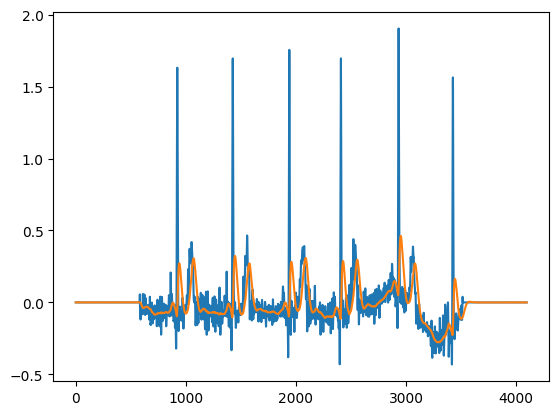

In [24]:
plt.plot(erro[0, :]);
plt.plot(lfilter(b, a, erro[0, :]));

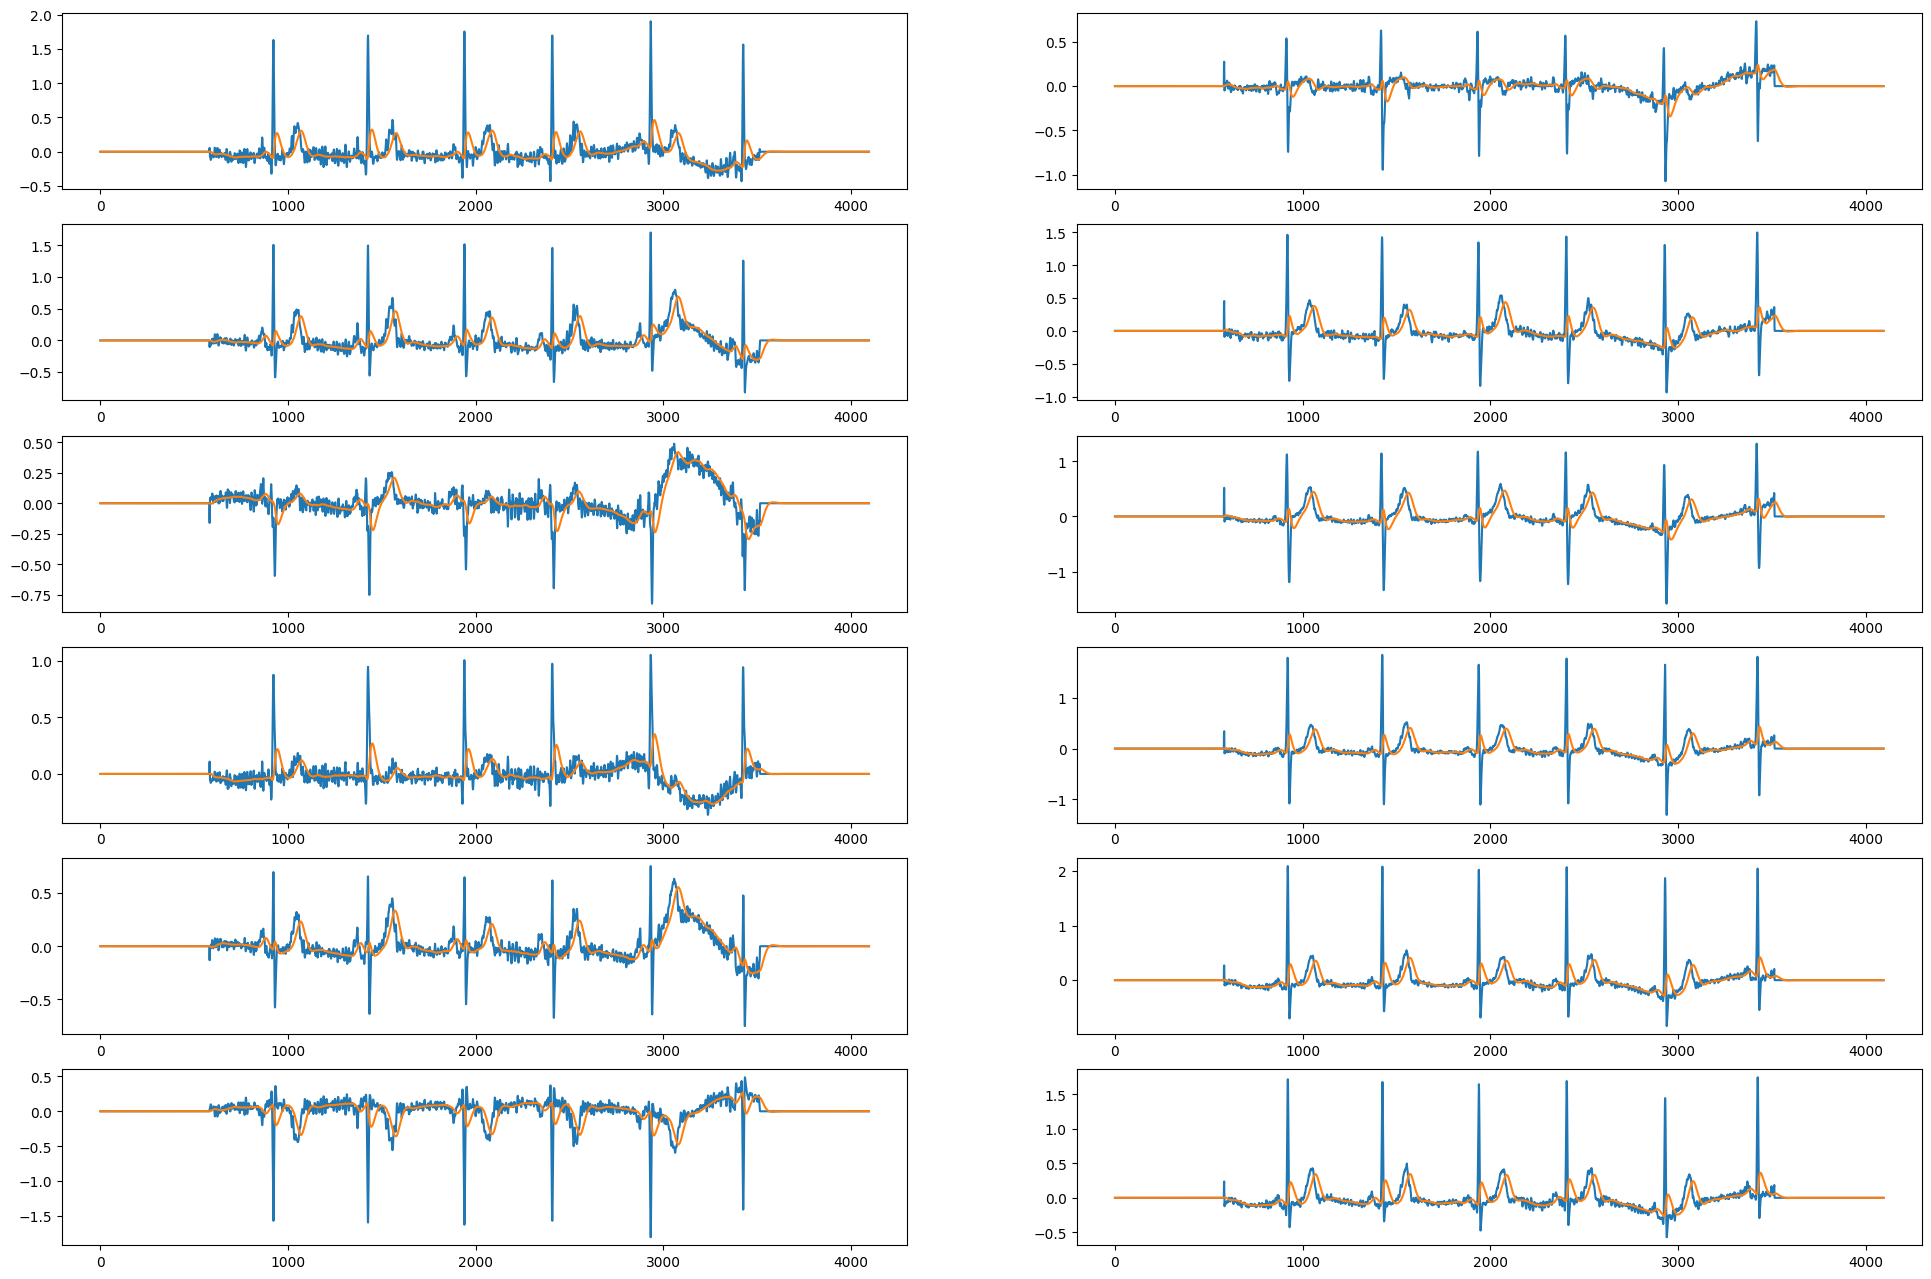

In [25]:
erros = ecg[error_idx]

s = 0
erro = erros[s, :, :]
fig, axs = plt.subplots(6, 2, figsize = (24, 16))
for ii in range(12):
    i = ii % 6
    j = ii // 6
    axs[i, j].plot(erro[ii, :]);
    axs[i, j].plot(lfilter(b, a, erro[ii, :]));

In [65]:
y = torch.clone(raw.permute(0, 2, 1))

for i in tqdm(range(y.shape[0])):
    for j in range(y.shape[1]):
        y[i, j, :] = torch.tensor(lfilter(b, a, y[i, j, :]))

raw.shape, y.shape

100%|██████████| 827/827 [00:00<00:00, 1203.53it/s]


(torch.Size([827, 4096, 12]), torch.Size([827, 12, 4096]))

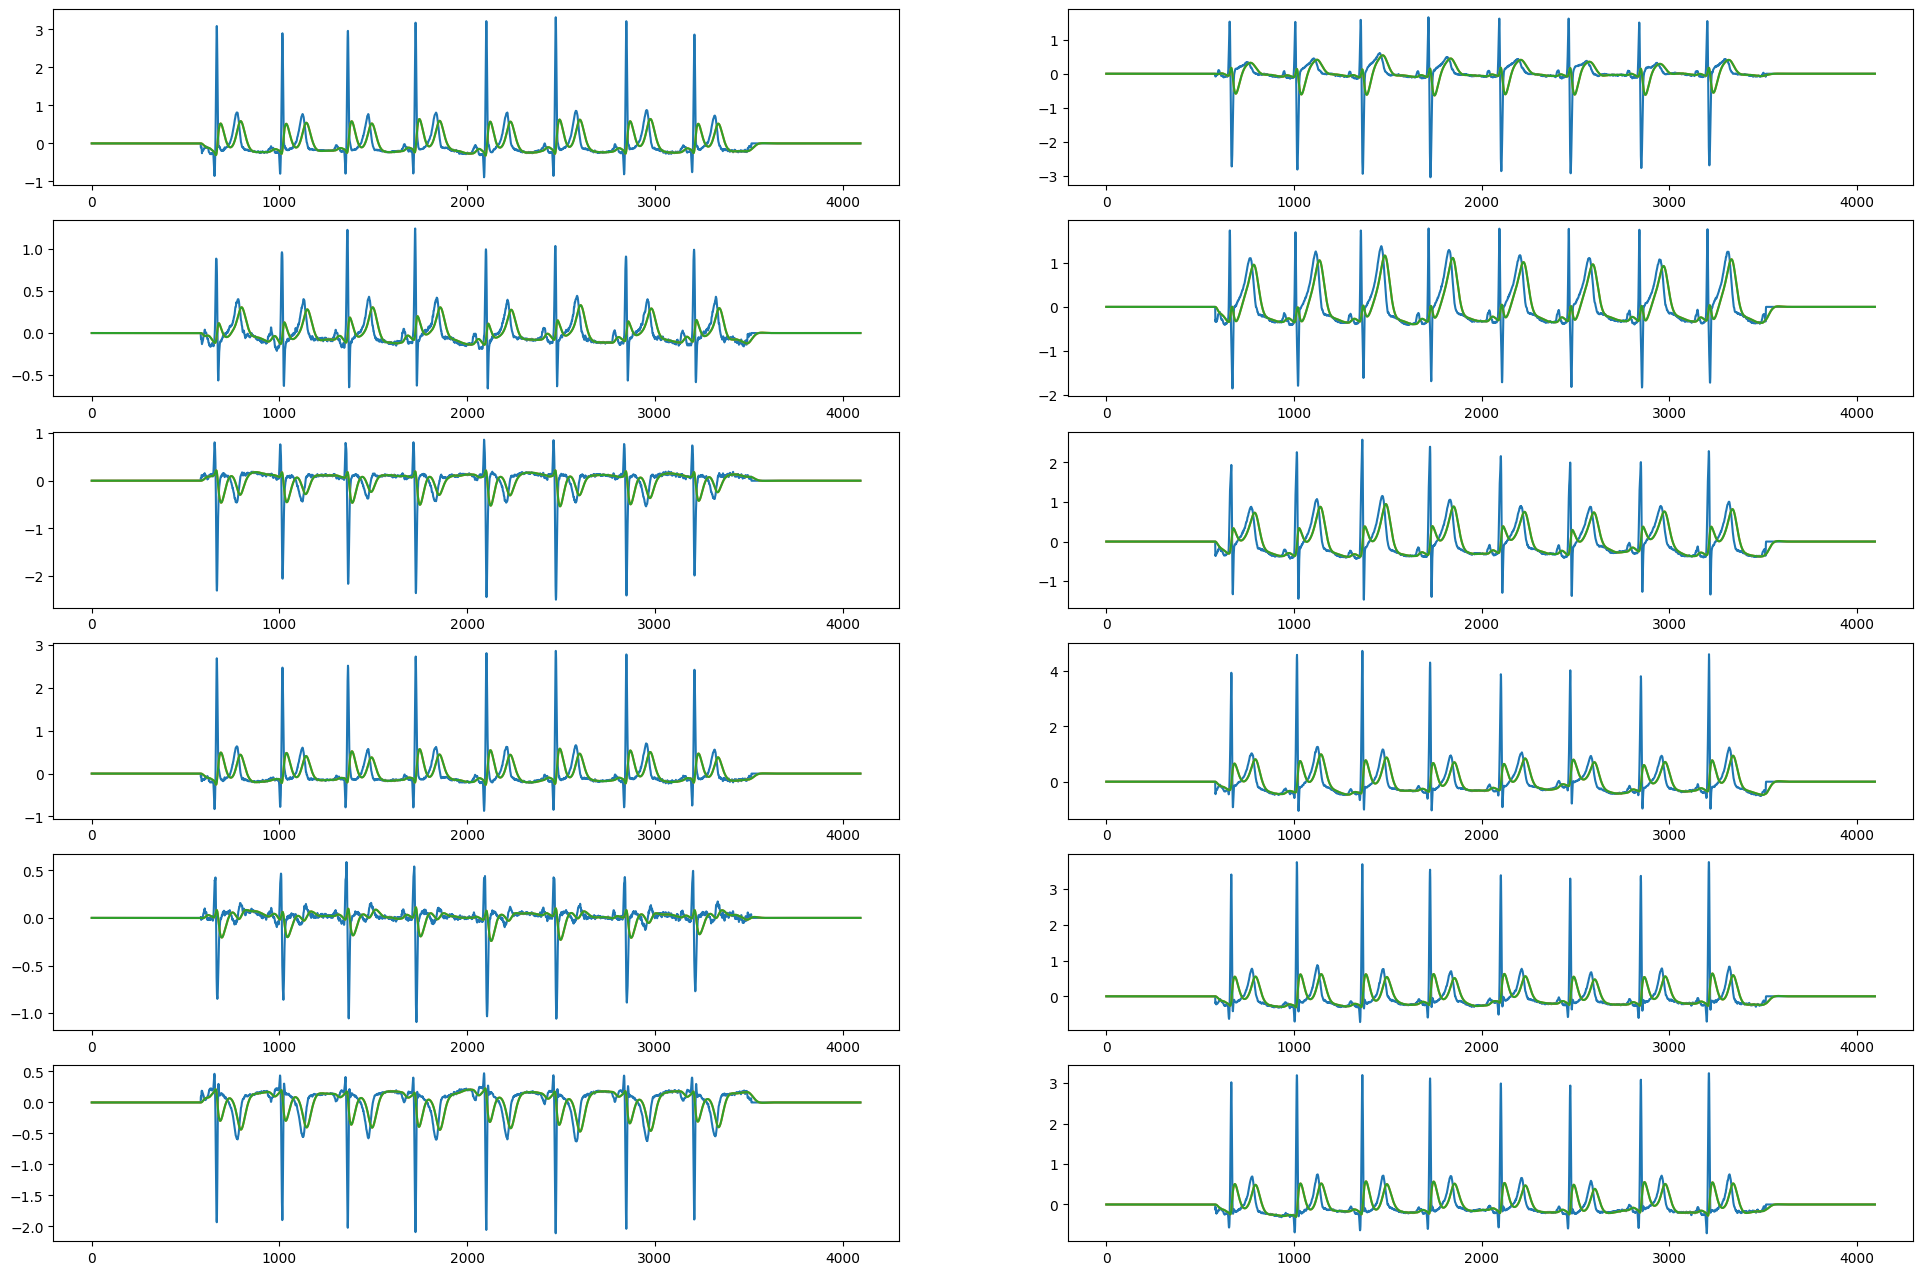

In [68]:
fig, axs = plt.subplots(6, 2, figsize = (24, 16))
for ii in range(12):
    i = ii % 6
    j = ii // 6
    axs[i, j].plot(raw[0, :, ii]);
    axs[i, j].plot(lfilter(b, a, raw[0, :, ii]));
    axs[i, j].plot(y[0, ii, :]);

# lowpass test

In [70]:
# def get_inputs(batch, apply = "non_zero", device = "cuda"):
def get_inputs(batch, apply = "nothing", device = "cuda"):
    # (B, C, L)
    if batch.shape[1] > batch.shape[2]:
        batch = batch.permute(0, 2, 1)
    
    fs = 400
    cutoff = 4
    b, a = butter(N = 2, Wn = cutoff, fs = fs)
    for i in tqdm(range(batch.shape[0])):
        for j in range(batch.shape[1]):
            batch[i, j, :] = torch.tensor(lfilter(b, a, batch[i, j, :]))

    B, n_leads, signal_len = batch.shape

    if apply == "non_zero":
        transformed_data = torch.zeros(B, n_leads, SIGNAL_CROP_LEN)
        for b in range(B):
            start = SIGNAL_NON_ZERO_START
            diff = signal_len - start
            if start > diff:
                correction = start - diff
                start -= correction
            end = start + SIGNAL_CROP_LEN
            for l in range(n_leads):
                transformed_data[b, l, :] = batch[b, l, start:end]

    else:
        transformed_data = batch.float()

    return transformed_data.to(device)

In [71]:
def synthesis(model, device, loader, best_thresholds):
    all_binary_results = []
    all_true_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader):
            # raw, exam_id, label = batch
            raw = batch['X']
            label = batch['y']
            ecg = get_inputs(raw, device = device)
            label = label.to(device).float()

            logits = model(ecg)
            probs = torch.sigmoid(logits)

            binary_result = torch.zeros_like(probs)
            for i in range(len(best_thresholds)):
                binary_result[:, i] = (
                    probs[:, i] >= best_thresholds[i]
                ).float()
            
            all_binary_results.append(binary_result)
            all_true_labels.append(label)
    
    all_binary_results = torch.cat(all_binary_results, dim=0)
    all_true_labels = torch.cat(all_true_labels, dim=0)
    return all_binary_results, all_true_labels, metrics_table(all_binary_results, all_true_labels)

In [72]:
_, _, metrics_dict_lptest = synthesis(model, device, tst_dl, best_thresholds)
metrics_dict_lptest

100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


{'Accuracy': [0.6396614268440145,
  0.9746070133010882,
  0.8137847642079806,
  0.9915356711003628,
  0.9854897218863361,
  0.9564691656590084,
  0.5006045949214026],
 'F1 Score': [0.10240963855421685,
  0.5531914893617021,
  0.26666666666666666,
  0.787878787878788,
  0.14285714285714288,
  0.052631578947368425,
  0.6070409134157945],
 'AUC ROC': [0.6239719291972108,
  0.6911764705882353,
  0.8713090757005437,
  0.9037839087546239,
  0.5384615384615384,
  0.5135135135135135,
  0.5595568563554804]}